# PCA analysis and first run of MLPC-based prediction

2023-10-25


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sklearn.set_config(transform_output="pandas")

In [2]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 120)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


def select_samples(name, n=None, sample_names_to_check=None):
    index_list = []
    for index, sample_description in enumerate(sample_names_to_check):
        if name in sample_description and len(name) == len(sample_description):
            index_list.append(index)

    return index_list[:n]


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


def to_normalize_rpm(data):
    # Normalise the gene counts to the library size
    data = data.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
    return data


def data_prep_pca(data):
    data = data.loc[:, data.sum(axis=0) > 10]
    data = to_normalize_rpm(data)
    data = np.log1p(data)
    data = scaler.fit_transform(data)

    return data


def data_prep_mlpc(data):  # the same steps as in the original MLPCseq pipeline
    under10rpm = (
        open("/home/t.afanasyeva/MATseq/library/MLPC_model/MLPC_genes_under_10.txt")
        .read()
        .split("\n")
    )
    mask = data.T.index.isin(under10rpm)
    data = data.T[~mask]
    data = scaler.fit_transform(data)  # zscore uses the same formula as the scaler
    data = data.T

    return data


def get_classes_batches(data):
    classes = []
    batches = []
    for name in data.index:
        parts = name.split("_")
        if name.startswith("BA"):
            batches.append("7128_old")
            classes.append(parts[-2])
        else:
            classes.append(parts[-2])
            batches.append(parts[1])

    return classes, batches

In [5]:
sns.set_context(
    "paper",
    rc={
        "font.size": 12,
        "axes.titlesize": 8,
        "axes.labelsize": 12,
        "figure.figsize": (240, 160),
    },
)


custom_palette_12 = [
    "#000000",
    "#8b4513",
    "#006400",
    "#000080",
    "#ff0000",
    "#ffa500",
    "#00ff7f",
    "#00ffff",
    "#ff00ff",
    "#eee8aa",
    "#6495ed",
    "#ff69b4",
]


custom_palette_24 = [
    "#000000",
    "#696969",
    "#8b4513",
    "#808000",
    "#3cb371",
    "#00008b",
    "#8b008b",
    "#ff4500",
    "#ffa500",
    "#ffff00",
    "#7fff00",
    "#00ff7f",
    "#4169e1",
    "#dc143c",
    "#00ffff",
    "#00bfff",
    "#0000ff",
    "#d8bfd8",
    "#ff00ff",
    "#db7093",
    "#f0e68c",
    "#ff1493",
    "#ffa07a",
    "#ee82ee",
]

In [6]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_106_samples.csv"
data = pd.read_csv(file_name, index_col="sample")

In [7]:
file_name = (
    "/home/t.afanasyeva/MATseq/notebooks/gene_counts_exp_B34_B44_B51_B61_B64.csv"
)
data_old_batch = pd.read_csv(file_name, index_col="sample")

Drop a sample with high IL-6 expression (BA028_IMDM_03).

In [8]:
data_old_batch = data_old_batch.drop(index="BA028_IMDM_03", axis=0)

In [9]:
processed_data_pca = data_prep_pca(data)
processed_data_old_pca = data_prep_pca(data_old_batch)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [11]:
classes, batches = get_classes_batches(processed_data_pca)
data_pca = pca.fit_transform(processed_data_pca)

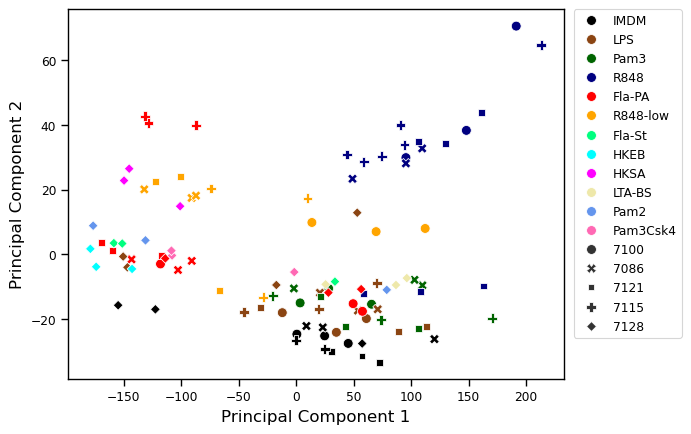

In [12]:
scatter = sns.scatterplot(
    x=data_pca.pca0,
    y=data_pca.pca1,
    hue=classes,
    style=batches,
    palette=custom_palette_12,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

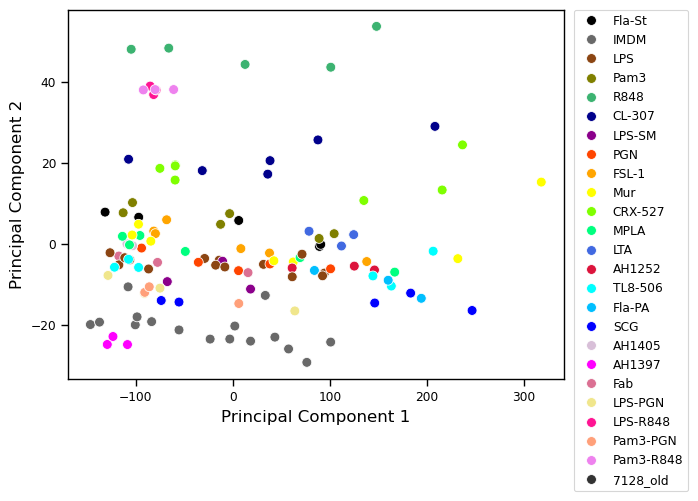

In [13]:
classes_old, batches_old = get_classes_batches(processed_data_old_pca)
data_old_pca = pca.fit_transform(processed_data_old_pca)

sns.set_context(
    "paper",
    rc={
        "font.size": 12,
        "axes.titlesize": 8,
        "axes.labelsize": 12,
        "figure.figsize": (240, 160),
    },
)


scatter = sns.scatterplot(
    x=data_old_pca.pca0,
    y=data_old_pca.pca1,
    hue=classes_old,
    style=batches_old,
    palette=custom_palette_24,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [14]:
data_combined = pd.concat([data, data_old_batch])
classes_combined, batches_combined = get_classes_batches(data_combined)

In [15]:
data_combined.head()

,HUNK,KLHL8,ZNF576,UGT1A5,FCF1,SLC2A7,FABP12,TAF12,GLRX,LAMB3,...,ASIC2,TSN,EVA1A,NFATC1,PORCN,GALNT17,DEPDC4,REL,RPL23,AHSP
sample,,,,,,,,,,,,,,,,,,,,,
MD211_7100_IMDM_1,0.0,59.0,34.0,0.0,95.0,0.0,0.0,63.0,42.0,166.0,...,0.0,255.0,0.0,203.0,9.0,0.0,0.0,1042.0,1903.0,0.0
MD211_7100_IMDM_2,0.0,84.0,13.0,0.0,204.0,0.0,0.0,31.0,24.0,107.0,...,0.0,128.0,0.0,141.0,13.0,0.0,0.0,1086.0,1540.0,1.0
MD211_7100_IMDM_3,0.0,33.0,15.0,0.0,121.0,0.0,0.0,47.0,26.0,75.0,...,0.0,169.0,0.0,138.0,9.0,0.0,0.0,800.0,1218.0,1.0
MD211_7100_LPS_1,0.0,55.0,41.0,0.0,135.0,0.0,0.0,53.0,46.0,131.0,...,0.0,143.0,0.0,181.0,17.0,0.0,0.0,870.0,1193.0,4.0
MD211_7100_LPS_2,0.0,75.0,45.0,0.0,196.0,0.0,0.0,49.0,69.0,177.0,...,0.0,317.0,0.0,233.0,17.0,0.0,0.0,1341.0,2254.0,4.0


I only take classes that are present in the new set to compare the batches of the new and the old set. I also removed HKEB and HKSA.

In [16]:
def subset_data(data, classes, classes_to_remove):
    data["classes"] = classes
    for i in classes_to_remove:
        data = data[data["classes"] != i]
    data = data.drop(columns="classes")

    return data

In [17]:
classes_unique = list(set(classes))

classes_to_remove = []
for i in classes_combined:
    if i in classes_unique:
        continue
    else:
        classes_to_remove.append(i)
    classes_to_remove.append("HKEB")
    classes_to_remove.append("HKSA")

In [18]:
data_combined_subset = subset_data(data_combined, classes_combined, classes_to_remove)

classes_combined_subset, batches_combined_subset = get_classes_batches(
    data_combined_subset
)
processed_combined_data_pca = data_prep_pca(data_combined_subset)

/tmp/ipykernel_2943486/2002138511.py:3: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  scatter = sns.scatterplot(


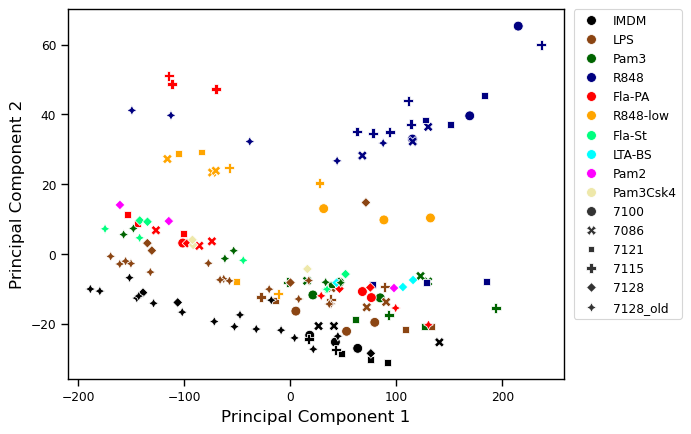

In [19]:
data_combined_subset_pca_pca = pca.fit_transform(processed_combined_data_pca)

scatter = sns.scatterplot(
    x=data_combined_subset_pca_pca.pca0,
    y=data_combined_subset_pca_pca.pca1,
    hue=classes_combined_subset,
    style=batches_combined_subset,
    palette=custom_palette_12,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [20]:
import pickle

model = pickle.load(
    open("/home/t.afanasyeva/MATseq/library/MLPC_model/MATseq_MLPC.model", "rb")
)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
X_test = data_prep_mlpc(data_combined_subset)

In [22]:
mlpc_results = pd.DataFrame(
    model.predict_proba(X_test), columns=list(model.classes_), index=list(X_test.index)
)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Text(69.91666666666666, 0.5, 'Sample')

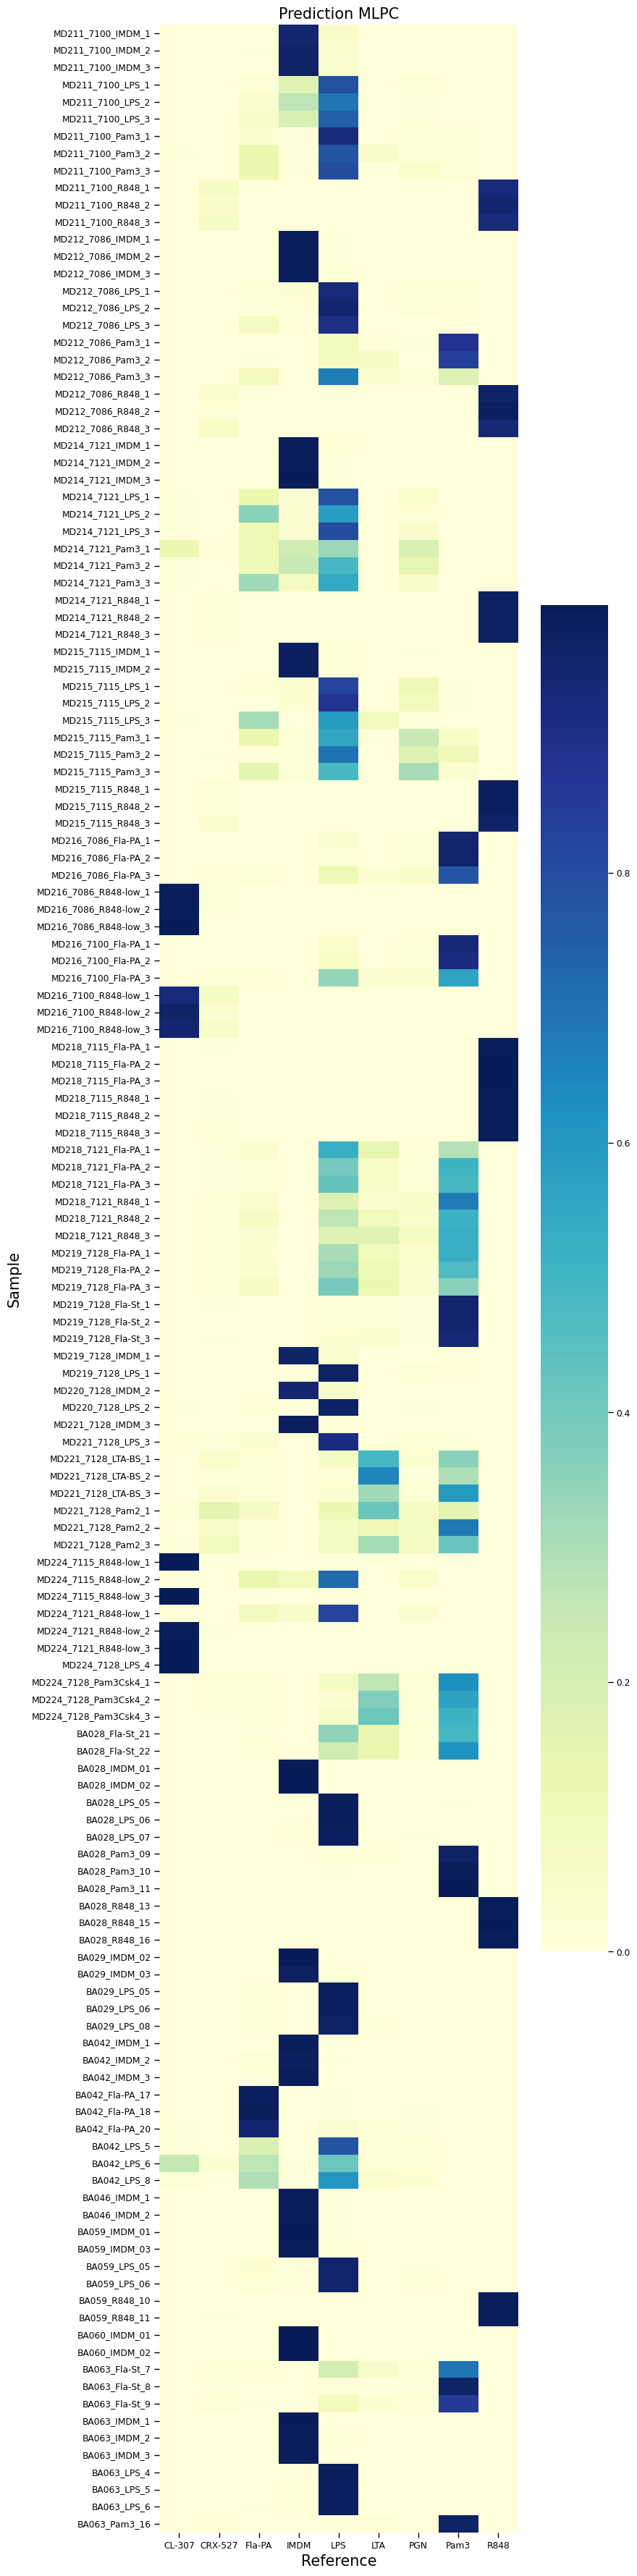

In [23]:
fig, ax = plt.subplots(figsize=(8, 45))
heat = sns.heatmap(mlpc_results.iloc[:-2], cmap="YlGnBu", ax=ax)

# Adjust layout for the second plot
heat.set_title(f"Prediction MLPC", fontsize=15)
heat.set_xlabel("Reference", fontsize=15)
heat.set_ylabel("Sample", fontsize=15, labelpad=10)

There seems to be no normalisation to the library size in the original MLPC_classification.py (see below, commented out) from the NATseq_ver1. I assume that the model was trained on the normalised data. Here added normalisation.

In [24]:
# import pandas as pd
# import os
# from load_exp_info import load_exp_info
# import pickle

# from scipy.stats import zscore as zscore
# from sklearn.neural_network import MLPClassifier


# def raw_to_zscore(DataFrame):
#     outputDF=pd.DataFrame(zscore(DataFrame, axis=0)
#                           ,index=DataFrame.index, columns=DataFrame.columns)
#     return(outputDF)


# log_filename=snakemake.log[0]

# exp_info,sample_dict=load_exp_info(log_filename)


# #loads MLPC model
# MLPC_model=pickle.load(open('library/MLPC_model/MATseq_MLPC.model', 'rb'))

# #loads list of under 10 rpm reads
# under10rpm=open('library/MLPC_model/MLPC_genes_under_10.txt').read().split('\n')

# #loads raw reads
# reads_raw=pd.read_csv(snakemake.input[0], index_col='gene')


# #creates test dataframe
# x_test=raw_to_zscore(reads_raw.drop(under10rpm,axis=0)).transpose()

# #runs prediction
# MLPC_results=pd.DataFrame(MLPC_model.predict_proba(x_test),columns=list(MLPC_model.classes_),index=list(x_test.index))

# ## saves prediction as excel and csv
# MLPC_results.to_excel(snakemake.output[0])
# MLPC_results.to_csv(snakemake.output[1])

In [25]:
def data_prep_mlpc_w_norm(data):
    data = to_normalize_rpm(data)  # Add library length normalisation step
    under10rpm = (
        open("/home/t.afanasyeva/MATseq/library/MLPC_model/MLPC_genes_under_10.txt")
        .read()
        .split("\n")
    )
    mask = data.T.index.isin(under10rpm)
    data = data.T[~mask]
    data = scaler.fit_transform(data)
    data = data.T

    return data

In [26]:
X_test_w_norm = data_prep_mlpc_w_norm(data_combined_subset)

In [27]:
mlpc_results = pd.DataFrame(
    model.predict_proba(X_test_w_norm),
    columns=list(model.classes_),
    index=list(X_test.index),
)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Text(69.91666666666666, 0.5, 'Sample')

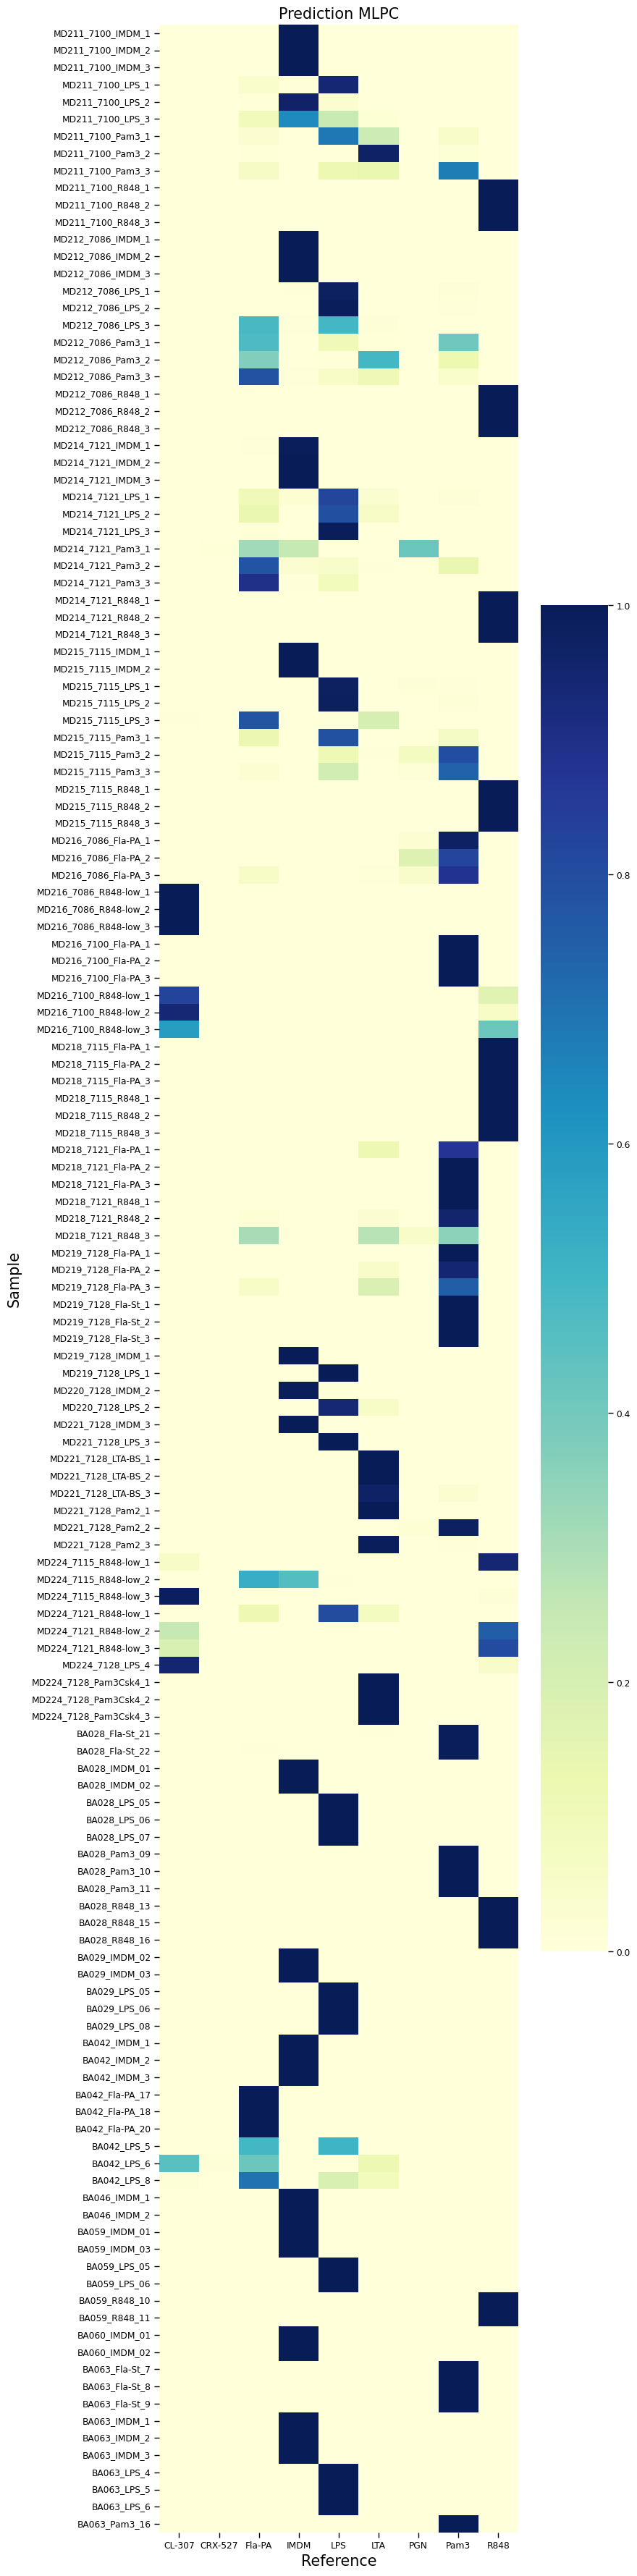

In [28]:
fig, ax = plt.subplots(figsize=(8, 45))
heat = sns.heatmap(mlpc_results.iloc[:-2], cmap="YlGnBu", ax=ax)

# Adjust layout for the second plot
heat.set_title(f"Prediction MLPC", fontsize=15)
heat.set_xlabel("Reference", fontsize=15)
heat.set_ylabel("Sample", fontsize=15, labelpad=10)

In [29]:
# Defines the best parameters for MLPC
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [53]:
from sklearn.neural_network import MLPClassifier


mlpc_new = MLPClassifier(**params)

In [54]:
file_name = "gene_counts_all_training_filtered.csv"
data_training = pd.read_csv(file_name, index_col="sample")

In [55]:
labels = data_training["class"]
features = data_training.drop(columns=["class"])

In [56]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# y_train = le.fit_transform(labels)

MLPC can take labels as string and then it's easier to have classes on the x axis of the graphs

In [64]:
y_train = labels

In [57]:
X_train = features
X_test = data_combined_subset

In [ ]:
import time
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
)
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)


feature_transformer = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("drop_constant_feature", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("cap_outliers", Winsorizer(capping_method="gaussian", tail="right", fold=3)),
    ]
)

feature_selector = Pipeline(
    [
        ("select_k_best", SelectKBest(chi2, k=1000)),
        (
            "trasnform_and_scale",
            PowerTransformer(method="yeo-johnson", standardize=True),
        ),
        ("select_forest", SelectFromModel(forest, threshold=0.001)),
    ]
)

print("Number of features before: ", X_train.shape[1])
start_time = time.time()


X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

feature_selector.fit(X_train, y_train)
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)

end_time = time.time()
print("Number of features after: ", X_train.shape[1])
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

In [70]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [71]:
mlpc_new.fit(X_train, y_train)

MLPClassifier(max_iter=600, random_state=0)

In [72]:
mlpc_results = pd.DataFrame(
    mlpc_new.predict_proba(X_test),
    columns=list(mlpc_new.classes_),
    index=list(X_test.index),
)

Text(69.91666666666666, 0.5, 'Sample')

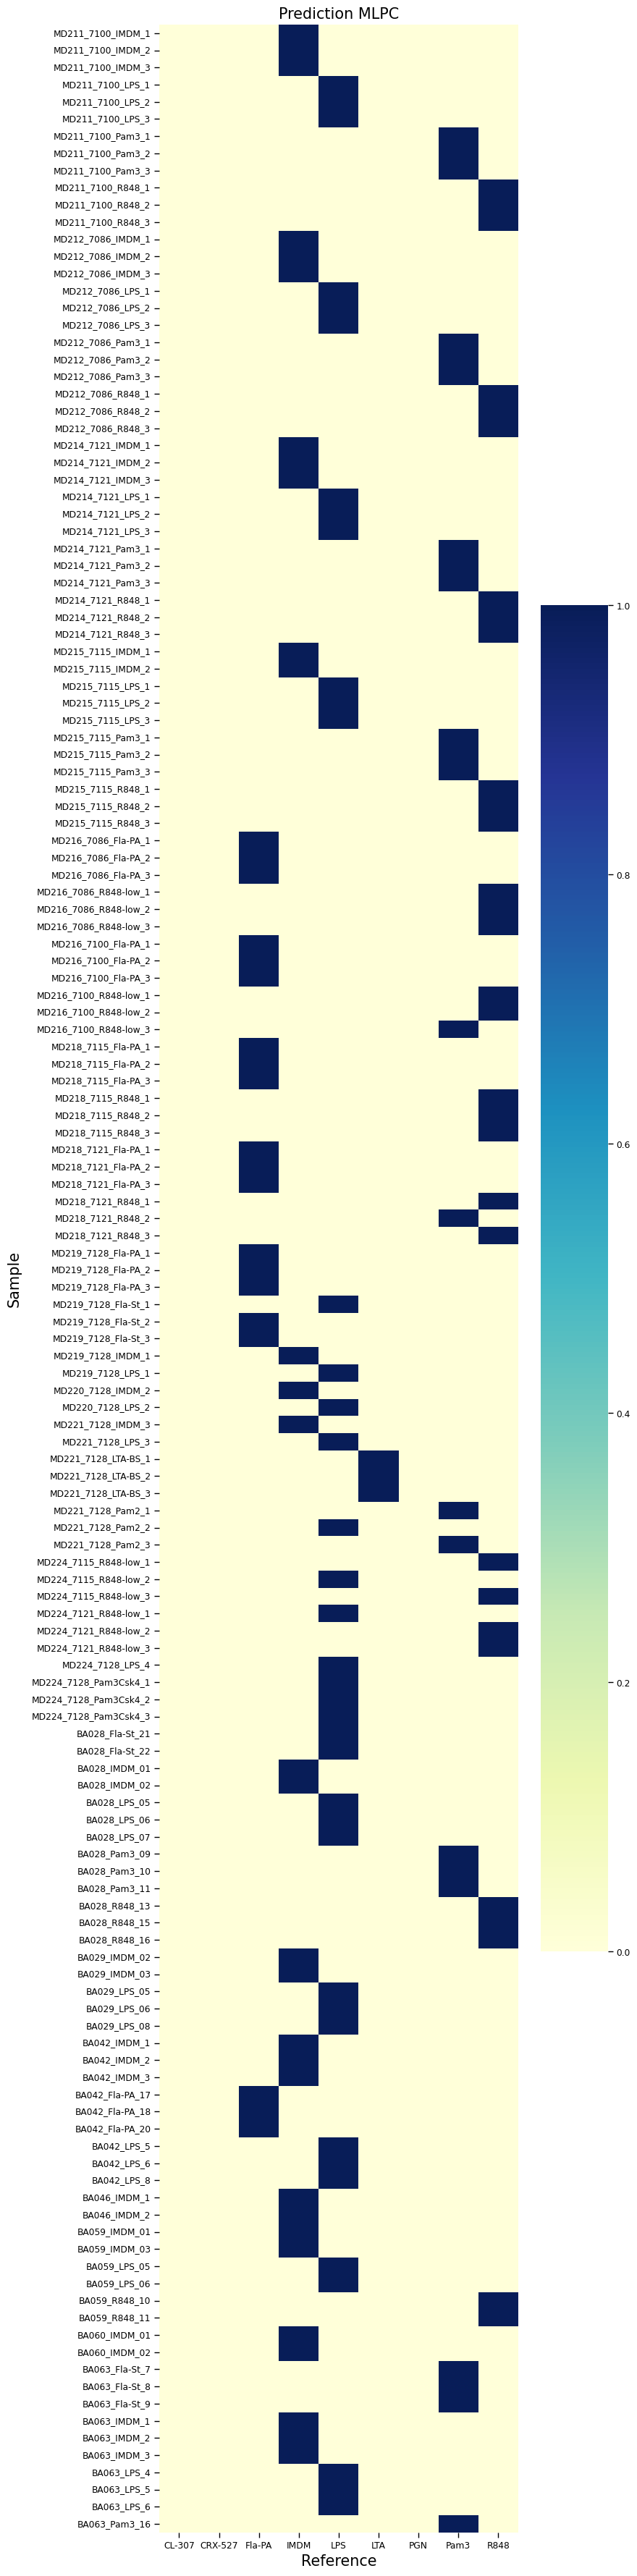

In [73]:
fig, ax = plt.subplots(figsize=(8, 45))
heat = sns.heatmap(mlpc_results.iloc[:-2], cmap="YlGnBu", ax=ax)

# Adjust layout for the second plot
heat.set_title(f"Prediction MLPC", fontsize=15)
heat.set_xlabel("Reference", fontsize=15)
heat.set_ylabel("Sample", fontsize=15, labelpad=10)

It seems that MLPC trained on the pipeline-processed data performes at the same level or better than the version 1 trained on the unprocessed subset data